# Chapter 4 lab: Logistic regression, LDA, QDA, and KNN.

### In this lab we will examine the *Smarket* data, which is part of the *ISLP* library. This data set consists of percentage returns for the S&P 500 stock index over 1250 days, from the beginning of 2001 until the end of 2005. For each data, we have recorded the percentage returns for ech of the five previous trading days, *Lag1* through *Lag5*. We have also recorded *Volume* (the number of shares traded on the previous day, in billions), *Today* (the percentage return on the data in question) and *Direction* (whether the market was *Up* or *Down* on tihs date). We start by importing our libraries at this top level; these are all imports seen in previous labs. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.metrics import accuracy_score,confusion_matrix
from patsy import dmatrices
import statsmodels.api as sm

In [2]:
# Load the Smarket data
df = pd.read_csv(r'C:\Users\User-PC\Documents\GitHub\Introduction-to-Statistical-Learning\Data sets\Smarket.csv')

In [3]:
# Show the columns of the data set
df.columns
df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


C:\Users\User-PC\AppData\Local\Temp\ipykernel_3880\2095372615.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


<Axes: >

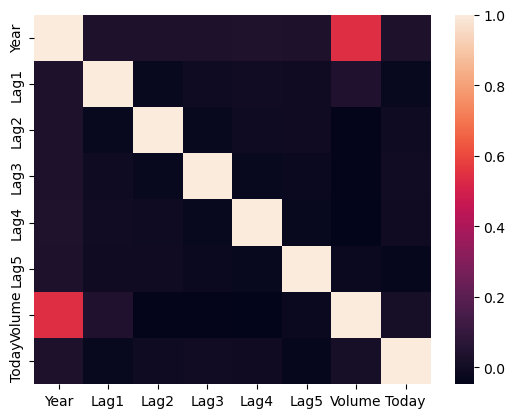

In [4]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot a heatmap of the correlation matrix
sns.heatmap(corr_matrix)

Text(0, 0.5, 'Volume')

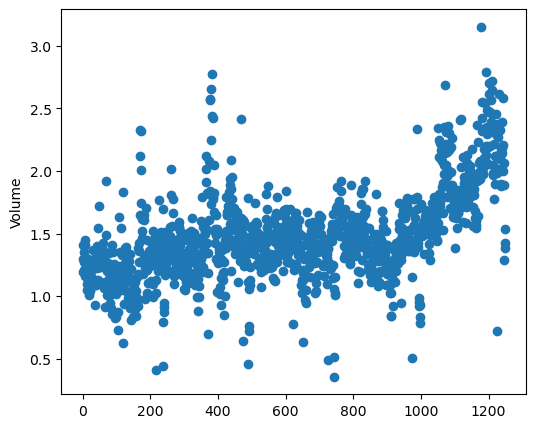

In [5]:
# Plot the volume of sales
fig, ax = plt.subplots(figsize= (6,5))
ax.scatter(x=df.index,y=df['Volume'])
ax.set_ylabel('Volume')

In [6]:
# Lets first create a new column called Direction_Up where 1=Up and 0=Down
df['Direction_Up'] = np.where(df['Direction'] == 'Up',1,0)

# Fit a logistic regression to predict Direction using Lag1 through Lag5 and Volume.
f = 'Direction_Up ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume'

# Set up the model
model_logist = sm.Logit.from_formula(formula=f, data=df)
results_logist = model_logist.fit()

display(results_logist.summary())

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Direction_Up   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Thu, 07 Mar 2024   Pseudo R-squ.:                0.002074
Time:                        20:31:47   Log-Likelihood:                -863.79
converged:                       True   LL-Null:                       -865.59
Covariance Type:            nonrobust   LLR p-value:                    0.7319
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.050     -1.457      0.145      -0.171       0.025
Lag2          -0.0423      0.050     -0.845      0.398      -0.140       0.056
Lag3           0.0111      0.050      0.222      0.824      -0.087       0.109
Lag4           0.0094      0.050      0.187      0.851      -0.089       0.107
Lag5           0.0103      0.050      0.208      0.835      -0.087       0.107
Volume         0.1354      0.158      0.855      0.392      -0.175       0.446
==============================================================================
"""

The smallest p-value here is assiciated with *Lag1*. The negative coefficient fot this predictor suggests that if the market had a positive return yesterday, then it is less likely to go up today. However, at a value of 0.15, the p-value is still relatively large, and there is no clear evidence of a real association between *Lag1* and *Direction*.

In [7]:
# Print the parameters
results_logist.params

Intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

In [8]:
#Print the p-values
results_logist.pvalues

Intercept    0.600700
Lag1         0.145232
Lag2         0.398352
Lag3         0.824334
Lag4         0.851445
Lag5         0.834998
Volume       0.392404
dtype: float64

In [9]:
# Print the confusion matrix
results_logist.pred_table(threshold=0.5)


array([[145., 457.],
       [141., 507.]])

In [10]:
probs = results_logist.predict()
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [11]:
labels = np.array(['Down']*1250)
labels[probs>0.5] = 'Up'

In [12]:
confusion_table(labels, df['Direction'])

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [13]:
(145+507)/1250 , np.mean(labels == df['Direction'])

(0.5216, 0.5216)

In [14]:
# Let's drop the Direction_Up field so we can continue with the book's examples
df = df.drop('Direction_Up', axis=1)
df.head()

# Create a train and a test set
train = (df['Year'] < 2005)
test = df.loc[~train]
test.shape

(252, 9)

In [15]:
# Define X and y
allvars = df.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(df)
y = df['Direction'] == 'Up'

# Define X_train, X_test, y_train, y_test
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

# Train the model
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results_logist1 = glm_train.fit()
probs = results_logist1.predict(X_test)

In [16]:
D = df['Direction']
L_train, L_test = D.loc[train], D.loc[~train]

labels = np.array(['Down']*252)
labels[probs>0.5] = 'Up'
confusion_table(labels,L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [17]:
print('The accuracy is ' + str(int(100*(44+77)/252,)) + '%')

The accuracy is 48%


In [18]:
round(np.mean(labels == L_test),3), round(np.mean(labels != L_test),3)

(0.48, 0.52)

In [19]:
# Remove low p-value predictors
model = MS(['Lag1','Lag2']).fit(df)
X = model.transform(df)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train,X_train,family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(X_test)
labels = np.array(['Down']*252)
labels[probs>0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [20]:
print('The accuracy is ' + str(int(100*(106+35)/252,)) + '%')

The accuracy is 55%


In [21]:
round(100*np.mean(labels == L_test),1), round(100*106/(106+76),1)

(56.0, 58.2)

In [22]:
# Make some predictions
new_data = pd.DataFrame({'Lag1' : [1.2, 1.5], 'Lag2' : [1.1, -0.8]})
new_X = model.transform(new_data)
results.predict(new_X)

0    0.479146
1    0.496094
dtype: float64

# Linear discriminant analysis (LDA)

In [23]:
# Linear discriminant analysis
lda = LDA(store_covariance=True)

# Create a tests and a train set, dropping the intercept as well
X_train, X_test = [M.drop(columns=['intercept']) for M in [X_train, X_test]]

# Fit the model
lda.fit(X_train,L_train)

LinearDiscriminantAnalysis(store_covariance=True)

### We can print the means of the classes, which are the estimates of $\mu_k$.

In [24]:
# We can print the classes like this:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

### The LDA output indicates that $\hat{\pi}_{down}$ = 0.492 and $\hat{\pi}_{up}$ = 0.508.

In [25]:
lda.priors_

array([0.49198397, 0.50801603])

In [26]:
# The linear discriminant vectors can be found using the scalings_ attribute
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

### These values provide the linear combinations of *Lag1* and *Lag2* that are used to form the LDA decision rule. In other words, these are the mulippliers of the elements of X = x in 4.24. If -0.64 x *Lag1* - 0.51 x *Lag2* is large, then the LDA classifier will predict a market increase, and if it is small, then then the LDA calssifier will predict a market decrease.

In [27]:
# Predictions
lda_pred = lda.predict(X_test)

In [28]:
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


### We can alos estimate the probability of each class for each point in a training set. Applying a 50% threshold to the posterior probabilities of being in class one allows us to recreate the predictions containted in *lda_pred*.

In [29]:
lda_prob = lda.predict_proba(X_test)
np.all(np.where(lda_prob[:,1] >= 0.5, 'Up', 'Down') == lda_pred)

True

In [30]:
np.all([lda.classes_[i] for i in np.argmax(lda_prob,1)] == lda_pred)

True

In [31]:
np.sum(lda_prob[:,0] > 0.9)

0

# Quadratic Discriminant Analysis (QDA)

### We will now fit a QDA model to the *Smarket* data. QDA is implemented via *QuadraticDiscriminantAnalysis()* in the *sklearn* package, which we abbreviate to *QDA()*. The syntax is very similar to *QDA()*.

In [32]:
# Fit the model
qda = QDA(store_covariance = True)
qda.fit(X_train,L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

### The *QDA()* function will again compute the *means_* and *priors_*.

In [33]:
qda.means_, qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

### The *QDA()* classifier will estimate one covariance per class. Here is the estimated covariance in the first class:

In [34]:
qda.covariance_[0]

array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

### The *predict()* function works in exactly the same fuashion as for LDA. 

In [35]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred,L_test)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [36]:
np.mean(qda_pred == L_test)

0.5992063492063492

# Naive Bayes

### Next, we fit a Naive Bayes model to the *Smarket* data. The syntax is similar to that of *LDA()* and *QDA()*. By default, this implementation *GaussianNM()* of the Naive Bayes classifier models each quantitative feature using a Gaussian distribution. However, a kernel density method can also be used to estimate the distributions. 

### The classes are stored as *classes_*.

In [37]:
NB = GaussianNB()
NB.fit(X_train,L_train)
NB.classes_

array(['Down', 'Up'], dtype='<U4')

### The class prior probabilities are stored in the *class_prior_* attribute.

In [38]:
NB.class_prior_

array([0.49198397, 0.50801603])

### The parameters of the features can be found in the *theta_* and *var_* attributes. The number of rows is equal to the number of classes, while the number of columns is equal to the number of features. We see below that the mean for the feature *Lag1* in the *Down* class is 0.043.

In [39]:
NB.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [40]:
NB.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

### How do we know hte names of these attributes? We use *NB?*.

In [41]:
#?NB # Commented out to hide output. 

### We can easily verify the mean:

In [42]:
X_train[L_train == 'Down'].mean()

Lag1    0.042790
Lag2    0.033894
dtype: float64

### Similarly for the variance:

In [43]:
X_train[L_train == 'Down'].var(ddof=0)

Lag1    1.503554
Lag2    1.532467
dtype: float64

### The *GaussianNB()* function calculates variances using the 1/n formula. Since *NB()* is a classifier in te *sklearn* library, making predictions uses the same syntax as for *LDA()* and *QDA()* above.

In [44]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels,L_test)

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


In [45]:
NB.predict_proba(X_test)[:5]

array([[0.4873288 , 0.5126712 ],
       [0.47623584, 0.52376416],
       [0.46529531, 0.53470469],
       [0.47484469, 0.52515531],
       [0.49020587, 0.50979413]])

# K-Nearest Neigbours (KNN)

### Similar to previously, we fit and predict using KNN. 

In [46]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred,L_test)

Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


### Calculate the accuracy:

In [47]:
(43+83)/252 , np.mean(knn1_pred == L_test)

(0.5, 0.5)

### KNN with K=1 sucks. Let's try K=3.

In [48]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3_pred = knn3.fit(X_train,L_train).predict(X_test)
np.mean(knn3_pred == L_test)

0.5317460317460317

### Slightly better with K=3. QDA gives the best results.

### Lets try a different data set and try KNN again

In [49]:
Caravan = pd.read_csv(r'C:\Users\User-PC\Documents\GitHub\Introduction-to-Statistical-Learning\Data sets\Caravan.csv')
Caravan.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No


In [50]:
Purchase = Caravan['Purchase']
Purchase.value_counts()

No     5474
Yes     348
Name: Purchase, dtype: int64

In [51]:
348/(348+5474)

0.05977327378907592

In [52]:
feature_df = Caravan.drop(columns=['Purchase'])

### Long story short: we need to scale/standardise the values such that KNN does not prioritise predictors based on the scale of the predictors.  

In [53]:
scaler = StandardScaler(with_mean=True,
                        with_std=True,
                        copy=True)

### *with_mean* indicates whether or not we should subtract the mean
### *with_std* indicates whether or not we should scale the columns to have standard deviation of 1 or nor. 
### *copy=True* indicates that we will always copy data, rather than trying to do calcuations in place where possible

In [54]:
scaler.fit(feature_df)
X_std = scaler.transform(feature_df)

In [55]:
feature_std = pd.DataFrame(X_std,columns=feature_df.columns)
feature_std.std()

MOSTYPE     1.000086
MAANTHUI    1.000086
MGEMOMV     1.000086
MGEMLEEF    1.000086
MOSHOOFD    1.000086
              ...   
AZEILPL     1.000086
APLEZIER    1.000086
AFIETS      1.000086
AINBOED     1.000086
ABYSTAND    1.000086
Length: 85, dtype: float64

### Standard deviations are not quite equal to 1. Why? Because some procedures us 1/n while others use 1/(n-1) for calculating the standard deviation. It's fine since the variables now have the same scale.

### Use *train_test_split()*:

In [56]:
test = Caravan.iloc[:1000,:]
train = Caravan.iloc[1000:,:]

X_train = train.drop('Purchase',axis = 1)
y_train = train['Purchase']
X_test = test.drop('Purchase',axis = 1)
y_test = test['Purchase']

In [57]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [58]:
# changing labels from string to binary
y_train = np.where(y_train == 'Yes',1,0)
y_test = np.where(y_test == 'Yes',1,0)

In [59]:
# KNN with n_neighbors = 1
knn_1 = KNeighborsClassifier(n_neighbors=1)
knn_1.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [60]:
pred = knn_1.predict(X_test)
cm = confusion_matrix(y_test,pred)
print('The accuracy for k = 1 is ',accuracy_score(y_test,pred))
print('Confusion Matrix')
pd.DataFrame(cm,columns = ['No','Yes'],index = ['No','Yes'])

The accuracy for k = 1 is  0.883
Confusion Matrix


,No,Yes
No,874,67
Yes,50,9


In [61]:
# KNN with n_neighbors = 3
knn_3 = KNeighborsClassifier(n_neighbors=3)

knn_3.fit(X_train,y_train)

pred = knn_3.predict(X_test)
cm = confusion_matrix(y_test,pred)
print('The accuracy for k = 3 is ',accuracy_score(y_test,pred))
print('Confusion Matrix')
pd.DataFrame(cm,columns = ['No','Yes'],index = ['No','Yes'])

The accuracy for k = 3 is  0.926
Confusion Matrix


,No,Yes
No,920,21
Yes,53,6


In [62]:
# KNN with n_neighbors = 5
knn_5 = KNeighborsClassifier(n_neighbors=5)

knn_5.fit(X_train,y_train)

pred = knn_5.predict(X_test)
cm = confusion_matrix(y_test,pred)
print('The accuracy for k = 5 is ',accuracy_score(y_test,pred))
print('Confusion Matrix')
pd.DataFrame(cm,columns = ['No','Yes'],index = ['No','Yes'])

The accuracy for k = 5 is  0.934
Confusion Matrix


,No,Yes
No,931,10
Yes,56,3


Text(0, 0.5, 'Test Accuracy')

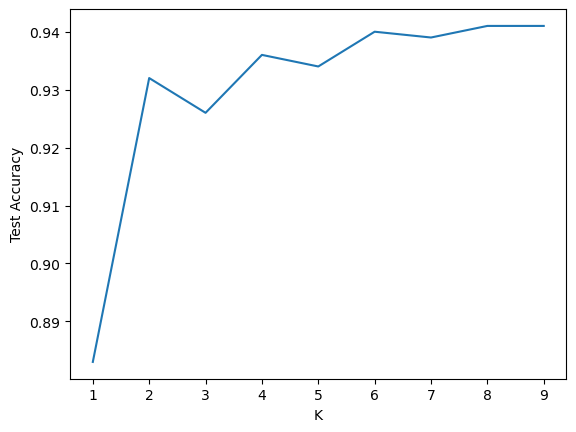

In [63]:
def knn_run(n):
    accuracy_list = []

    for n in range(1,n):
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(X_train, y_train)
        pred = knn.predict(X_test)
        accuracy_list.append(accuracy_score(y_test,pred))
    return accuracy_list

accuracy_list = knn_run(10)
x = np.arange(1,10,1)
plt.plot(x,accuracy_list)
plt.xlabel('K')
plt.ylabel('Test Accuracy')

# Linear and Poisson Regression

### Here we fit a Possion regression models on the *Bikeshare* data, as described in *Section 4.6*. The response *bikers* measures the number of boke rentals per hour in Washington, DC in the period 2010-2012.

In [64]:
# Import data
Bike = pd.read_csv(r'C:\Users\User-PC\Documents\GitHub\Introduction-to-Statistical-Learning\Data sets\Bikeshare.csv')

In [65]:
Bike.shape, Bike.columns

((8645, 16),
 Index(['Unnamed: 0', 'season', 'mnth', 'day', 'hr', 'holiday', 'weekday',
        'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
        'casual', 'registered', 'bikers'],
       dtype='object'))

In [66]:
X = MS(['mnth','hr','workingday','temp','weathersit']).fit_transform(Bike)
Y = Bike['bikers']

hr_encode = contrast('hr', 'sum')
mnth_encode = contrast('mnth', 'sum')

In [67]:
hr_encode

Column(idx='hr', name='hr', is_categorical=True, is_ordinal=False, columns=(), encoder=Contrast(method='sum'))

In [68]:
X2 = MS([mnth_encode,hr_encode,'workingday','temp','weathersit']).fit_transform(Bike)

### I get errors when I run the code in the book, will need to return to it later.